In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Business Understanding

In [72]:
mental_health_df = pd.read_excel('ChiEAC CARES Survey.xlsx')

In [73]:
# Clean up the messy column names
mental_health_df.rename(columns={
    'What YEAR were you born?': 'BirthYear',
    'What is your GENDER identity?': 'Gender Identity',
    'What is your RACIAL/ETHNIC identity?': 'Race/Ethnicity',
    'What is the ZIP CODE where you currently live? ': 'Zip Code',
    'What is your EMPLOYMENT STATUS (e.g., full-time, unemployed, student, etc.) currently?' : 'Employment Status',
    'On a scale from 1-10, please rate the CURRENT LEVEL OF STRESS you are experiencing.': 'Stress Level',
    'On a scale from 1-10, please rate your COMFORT SEEKING THERAPY to help cope with stress you are experiencing.': 'Potential Therapy',
    "Can you describe how you usually express your feelings when you're stressed or upset?\n\nFor example, some people stay really quiet, some people cry, others might get irritated or just want to be alone for a while. If you speak more than one language, feel ": 'Expressed feelings when stressed',
    "What words or phrases do you use to describe feeling overwhelmed or anxious?\n\nSome people say things like “I feel off,” “my chest is tight,” “I’m not okay,” or even just “I’m tired.” You can include phrases you use in English or any other language you spe": 'Expressed feelings when overwhelmed',
    "When you're dealing with a difficult situation, what kind of support or responses do you find most helpful?\n\nLike when things are heavy, do you want someone to just listen? Give you advice? Sit with you in silence? Say something specific? Feel free to mix": 'Helpful support',
    'Are there certain topics or ways of speaking that make you feel more comfortable when talking about personal challenges?\n\nSome people like it when the conversation feels casual or when the person uses words that feel more like home. If this changes depend': 'Helpful conversation topics and tone',
    "How do you prefer someone to approach you when they notice you're going through a tough time?\n\nMaybe a short message, maybe asking you to take a walk, or maybe just being near you helps. If there’s a word or phrase in your home language that feels right, ": 'Preferred approach of support',
    "Can you share any cultural, community, or calming practices that help you deal with stress or trauma?\n\nThis might include praying, deep breathing, cooking certain foods, going for walks, listening to music, dancing, journaling, or even just being around c": "Practices to deal with stress",
    "What are some signs that you’re starting to feel better after a stressful experience?\n\nMaybe you laugh again, or stop thinking about something as much, or start eating and sleeping better. If you use different words in English or another language to descr": "Stress recovery",
    "Are there specific words or phrases that you find comforting or encouraging?\n\nSome people feel better when they hear “you’re doing great,” “échale ganas,” “I’m with you,” or other phrases. Include anything in English or other languages that feels right to": "Comforting words or phrases",
    "Is there anything else you’d like to share about how you communicate during challenging times?\n\nMaybe how you act changes, or how you speak shifts between English and another language. We want to learn from you, so feel free to write in whichever language": "Extra Comments"
}, inplace=True)


In [74]:
mental_health_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 17 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Timestamp                             61 non-null     datetime64[ns]
 1   BirthYear                             59 non-null     float64       
 2   Gender Identity                       61 non-null     object        
 3   Race/Ethnicity                        61 non-null     object        
 4   Zip Code                              59 non-null     float64       
 5   Employment Status                     61 non-null     object        
 6   Stress Level                          61 non-null     int64         
 7   Potential Therapy                     61 non-null     int64         
 8   Expressed feelings when stressed      57 non-null     object        
 9   Expressed feelings when overwhelmed   59 non-null     object        
 10  Help

In [75]:
mental_health_df["BirthYear"] = mental_health_df["BirthYear"].astype('Int64')
mental_health_df['Zip Code'] = mental_health_df['Zip Code'].astype('Int64')

In [76]:
mental_health_df.drop(columns=[
    'Timestamp', 'Zip Code', 'Expressed feelings when stressed', 'Expressed feelings when overwhelmed',
    'Helpful support', 'Helpful conversation topics and tone', 'Preferred approach of support',
    'Practices to deal with stress', 'Stress recovery', 'Comforting words or phrases', 'Extra Comments'], inplace=True)

In [77]:
mental_health_df.sample(5)

,BirthYear,Gender Identity,Race/Ethnicity,Employment Status,Stress Level,Potential Therapy
16,2006,Female,Assyrian,Employment,3,9
56,2002,male,African American,part time,4,3
39,2005,Female,Black,student and part time work,6,10
14,2006,Female,White,Part time,10,3
1,2004,Female,White,Student,6,1


In [78]:
# Step 1 Normalize the cases
mental_health_df['Gender Identity'] = (
    mental_health_df['Gender Identity']
    .str.replace(r'[(),/]', ' ', regex=True)  # remove commas and parentheses
    .str.replace(r'\s+', ' ', regex=True)    # normalize spaces
    .str.strip()
    .str.lower()
)


# Step 2
mental_health_df['Gender Identity'] = mental_health_df['Gender Identity'].replace(to_replace=r'.*\b(she|female|woman|female|women).*\b', value='female', regex=True)
mental_health_df['Gender Identity'] = mental_health_df['Gender Identity'].replace(to_replace=r'.*\b(male|man|he|him).*\b', value='male',regex=True)

In [79]:
mental_health_df['Gender Identity'].unique()

array(['female', 'male', 'non-binary'], dtype=object)

In [80]:
mental_health_df.sample(5)

,BirthYear,Gender Identity,Race/Ethnicity,Employment Status,Stress Level,Potential Therapy
49,2000,female,Asian,Student/ Part-time,6,3
52,1997,female,Mexican/Latina,Full-time,8,4
7,2005,male,Caucasian / White,Part-time employed & full-time student.,7,4
8,1991,female,White,Student,4,10
5,2005,male,hispanic,employed (30 hour weeks),6,4


In [81]:
mental_health_df['Race/Ethnicity'] = (mental_health_df['Race/Ethnicity']
                                        .str.strip()
                                        .str.lower())

replace_map = {
    'assyrian': 'Asian',
    'white': 'European / White',
    'caucasian' : 'European / White',
    'caucasian / white': 'European / White',
    'white (probably like irish german)' : 'European / White', 
    'hispanic': 'Hispanic / Latino',
    'mexican': 'Hispanic / Latino',
    'latino': 'Hispanic / Latino',
    'latina': 'Hispanic / Latino',
    'latinx': 'Hispanic / Latino',
    'hispanic/latin' : 'Hispanic / Latino',
    'hispanic/latino' : 'Hispanic / Latino',
    'mexican/latina' : 'Hispanic / Latino',
    'black': 'African / African American',
    'african american': 'African / African American',
    'indian': 'Asian',
    'south asian': 'Asian',
    'filipino': 'Asian',
    'afghan': 'Asian',
    'middle eastern': 'Middle Eastern',
    'mexican american' : 'Mixed',
    'white/latina' : 'Mixed',
    'irish/ hispanic' : 'Mixed',
    'white, part turkish' : 'Mixed',
   'white/hispanic' : 'Mixed',
   'asian' : 'Asian',
   'hispanic / latino' : 'Hispanic / Latino',
    'european / white' : 'European / White',
    'mixed' : 'Mixed',
    'african / african american' : 'African / African American',
}

mental_health_df.loc[mental_health_df['Race/Ethnicity'] == 'catholic', 'Race/Ethnicity'] = 'Unknown'

mental_health_df['Race/Ethnicity'] = mental_health_df['Race/Ethnicity'].replace(replace_map)


In [82]:
mental_health_df['Employment Status'] = (mental_health_df['Employment Status'].str.strip().
                    str.lower()
                    .replace(r"[ ,\-]", "", regex=True))

replace_map2 = {'full time student and part-time worker' : 'Student and Employed', 
                'student' : 'Student',
                'parttimeandstudent' : 'Student and Employed',
                'employed(30hourweeks)' : 'Employed',
                'parttime' : 'Employed',
                'parttimeemployed&fulltimestudent.' : 'Student and Employed',
                'fulltimestudentandparttimeworker' : 'Student and Employed',
                'parttimework+fulltimeschool' : 'Student and Employed',
                'parttime/student' : 'Student and Employed',
                'studentemployee' : 'Student and Employed',
                'employment' : 'Employed',
                'unemployedstudent' : 'Student and Employed',
                'fulltime&halftimestudent' : 'Student and Employed',
                'unemployed' : 'Unemployed',
                'parttimestudent' : 'Student and Employed',
                'fulltimeworkandstudent' : 'Student and Employed',
                'employed' : 'Employed',
                'parttimeworkerandparttimestudent' : 'Student and Employed',
                'seasonalstartingwhenthissemester' : 'Student and Employed',
                'studentandparttimework' : 'Student and Employed',
                'fulltimeandstudent' : 'Student and Employed',
                'labspecialist' : 'Employed',
                'selfemployed' : 'Self-Employed',
                'studentandparttime' : 'Student and Employed',
                'unemployed/selfemployed' : 'Self-Employed',
                'student/parttime' : 'Student and Employed',
                'unemployed(f1opt)' : 'Unemployed',
                'fulltime' : 'Employed'}

mental_health_df['Employment Status'] = mental_health_df['Employment Status'].replace(replace_map2)

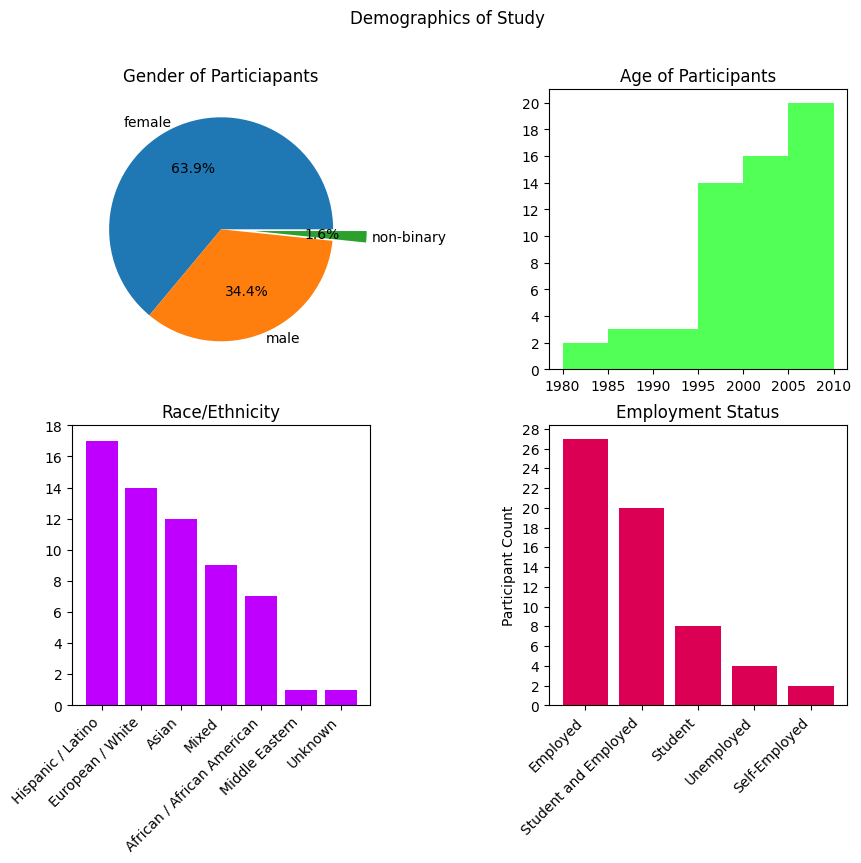

In [83]:
fig, arr = plt.subplots(2,2,figsize=(10,8))
fig.suptitle("Demographics of Study")

mtofpercent = mental_health_df['Gender Identity'].value_counts(normalize=True) * 100
arr[0,0].pie(mtofpercent, labels=mtofpercent.index, autopct='%1.1f%%', explode=[0,0,0.3], labeldistance=1.05)
arr[0,0].set_title('Gender of Particiapants')
plt.subplots_adjust(wspace=0.6)

birthyear = mental_health_df['BirthYear']
bins = np.arange(1980,2015, 5)
arr[0,1].hist(birthyear, bins = bins, color="#00FF08AD")
arr[0,1].set_yticks(np.arange(0,22, 2))
arr[0,1].set_title('Age of Participants')

arr[1,0].set_title('Race/Ethnicity')
rande = mental_health_df['Race/Ethnicity'].value_counts()
arr[1,0].bar(rande.index, rande, color="#BF00FF")
arr[1, 0].set_xticks(range(len(rande.index)))
arr[1, 0].set_xticklabels(rande.index, rotation=45, size=10, ha='right')
arr[1,0].set_yticks(np.arange(0,20,2))

arr[1,1].set_title('Employment Status')
empstat = mental_health_df['Employment Status'].value_counts()
arr[1,1].bar(empstat.index, empstat, color="#DC0054")
arr[1,1].set_ylabel('Participant Count')
arr[1,1].set_xticks(range(len(empstat)))
arr[1,1].set_xticklabels(empstat.index,rotation=45,ha='right')
arr[1,1].set_yticks(np.arange(0,30,2))


plt.show()

In [84]:
mental_health_df.drop(columns=['Race/Ethnicity'], inplace=True)

In [85]:
mental_health_df.head()

,BirthYear,Gender Identity,Employment Status,Stress Level,Potential Therapy
0,2006,female,Student and Employed,8,2
1,2004,female,Student,6,1
2,2004,female,Student and Employed,7,8
3,2005,female,Employed,10,9
4,2003,male,Student and Employed,6,10


In [86]:
mental_health_df.head()

,BirthYear,Gender Identity,Employment Status,Stress Level,Potential Therapy
0,2006,female,Student and Employed,8,2
1,2004,female,Student,6,1
2,2004,female,Student and Employed,7,8
3,2005,female,Employed,10,9
4,2003,male,Student and Employed,6,10


/var/folders/1f/d_gx42r56t114ydmx4hkjns40000gn/T/ipykernel_29597/4155157182.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data= mental_health_df, x = 'Stress Level', palette='Set2')


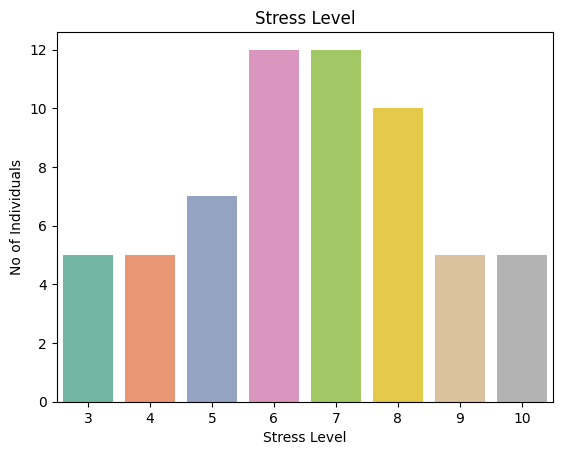

In [87]:
sns.countplot(data= mental_health_df, x = 'Stress Level', palette='Set2')
plt.title("Stress Level")
plt.ylabel('No of Individuals')
plt.show()

# Model Trainer

In [88]:
mental_health_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61 entries, 0 to 60
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   BirthYear          59 non-null     Int64 
 1   Gender Identity    61 non-null     object
 2   Employment Status  61 non-null     object
 3   Stress Level       61 non-null     int64 
 4   Potential Therapy  61 non-null     int64 
dtypes: Int64(1), int64(2), object(2)
memory usage: 2.6+ KB


In [89]:
mental_health_df = mental_health_df.dropna()

In [90]:
def categorize_stress(score):
    if score <= 3:
        return "Low"
    elif score <= 6:
        return "Medium"
    else:
        return "High"

In [91]:
mental_health_df['Stress Category'] = mental_health_df['Stress Level'].apply(categorize_stress)

In [92]:
import os
# Make sure the folder exists
os.makedirs('Cleaned Data', exist_ok=True)
# Save the cleaned data **inside the folder**
mental_health_df.to_excel('Cleaned Data/mental_health_df.xlsx', index=False)

In [93]:
# Scaling the Data
# Separate features and target
x = mental_health_df.drop(columns=['Stress Level'])
y = mental_health_df['Stress Level']

In [94]:
x.isna().sum()


BirthYear            0
Gender Identity      0
Employment Status    0
Potential Therapy    0
Stress Category      0
dtype: int64

In [95]:
# Encoding
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Column Categorization
num_features = x.select_dtypes(exclude='object').columns.tolist()
cat_features = x.select_dtypes(include='object').columns.tolist()


In [96]:
from sklearn.model_selection import train_test_split

# Split the full dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

In [97]:
# Creating Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_features),
        ('cat', categorical_transformer, cat_features)
    ]
)

In [98]:
import pandas as pd

# Fit the preprocessor
x_train_transformed = preprocessor.fit_transform(x_train)
x_test_transformed = preprocessor.transform(x_test)

In [99]:
def evaluate_model(true, predicted):
    acc = accuracy_score(true, predicted)
    prec = precision_score(true, predicted, average='weighted', zero_division=0)
    rec = recall_score(true, predicted, average='weighted', zero_division=0)
    f1 = f1_score(true, predicted, average='weighted', zero_division=0)
    conf_matrix = confusion_matrix(true, predicted)
    report = classification_report(true, predicted, zero_division=0)
    
    return acc, prec, rec, f1, conf_matrix, report

In [100]:
models = {
    "LogisticRegression" : LogisticRegression(),
    "Random Forest Classifier": RandomForestClassifier(),
    "CatBoosting Classifier": CatBoostClassifier(verbose=False),
}

results = []

for name, model in models.items():
    # Train the model
    model.fit(x_train_transformed,y_train)

    # Predictions
    y_train_pred = model.predict(x_train_transformed)
    y_test_pred = model.predict(x_test_transformed)

    # Evaluate
    train_acc, train_prec, train_rec, train_f1, train_cm, train_report = evaluate_model(y_train, y_train_pred)
    test_acc, test_prec, test_rec, test_f1, test_cm, test_report = evaluate_model(y_test, y_test_pred)


    results.append({
    "Model": name,
    "Train Accuracy": train_acc,
    "Test Accuracy": test_acc,
    "Train Precision": train_prec,
    "Test Precision": test_prec,
    "Train Recall": train_rec,
    "Test Recall": test_rec,
    "Train F1 Score": train_f1,
    "Test F1 Score": test_f1
    })

results_df = pd.DataFrame(results)
print(results_df)


                      Model  Train Accuracy  Test Accuracy  Train Precision  \
0        LogisticRegression        0.659574       0.333333         0.659574   
1  Random Forest Classifier        0.978723       0.416667         0.980851   
2    CatBoosting Classifier        0.978723       0.333333         0.980851   

   Test Precision  Train Recall  Test Recall  Train F1 Score  Test F1 Score  
0        0.277778      0.659574     0.333333        0.620365       0.291667  
1        0.416667      0.978723     0.416667        0.978316       0.416667  
2        0.388889      0.978723     0.333333        0.978316       0.350000  
